In [ ]:
import os
import requests
import pandas as pd

API_KEY = os.environ.get("API_KEY")
url = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/historical"

parameters = {
    "symbol": "BTC",
    "convert": "USD",
    "interval": "24h",
    "count": 100
}

headers = {
    "Accepts": "application/json",
    "X-CMC_PRO_API_KEY": API_KEY,
}

try:
    response = requests.get(url, headers=headers, params=parameters)
    response.raise_for_status()  # Raise exception for HTTP errors
    data = response.json()
    print("DATA: ", data)
    
    btc_data = data["data"]["BTC"][0]["quotes"]
    all_quotes = [item["quote"]["USD"] for item in btc_data]
    print("QUOTES: ", all_quotes)

    df_quotes = pd.DataFrame(all_quotes)
    df_quotes.to_csv("quotes.csv")

except Exception as e:
    print(e)


In [18]:
import pandas as pd

df_btc = pd.read_csv("./quotes.csv")
df_btc["timestamp"] = df_btc["timestamp"].apply(lambda x: x[:10])
print(df_btc["timestamp"])
df_btc = df_btc.astype({"timestamp": "datetime64[s]"}).set_index("timestamp")
df_btc.head()

0     2024-08-21
1     2024-08-22
2     2024-08-23
3     2024-08-24
4     2024-08-25
         ...    
95    2024-11-24
96    2024-11-25
97    2024-11-26
98    2024-11-27
99    2024-11-28
Name: timestamp, Length: 100, dtype: object


,Unnamed: 0,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply
timestamp,,,,,,,,,,
2024-08-21,0,-0.259023,3.119146,3.822595,-9.291341,61220.255035,3.230223e+10,1.208683e+12,19743196,19743196
2024-08-22,1,-0.366595,-1.457215,4.719244,-8.518946,60328.144488,2.804668e+10,1.191099e+12,19743678,19743678
2024-08-23,2,-0.392219,6.412008,9.026376,-1.725949,64196.389701,4.164920e+10,1.267505e+12,19744178,19744178
2024-08-24,3,0.416369,-0.385213,7.679103,-2.732526,63949.097035,2.225770e+10,1.262655e+12,19744696,19744696
2024-08-25,4,0.251679,1.101118,8.943554,-4.825128,64653.252252,1.750459e+10,1.276586e+12,19745112,19745112


In [19]:
import numpy as np

def calc_rolling_stats(ser, wd_size=7):
    """
    Takes in a series and returns the rolling mean and the rolling std for a window of size wd_size
    """
    
    rolling_mean, rolling_std = np.zeros(len(ser)), np.zeros(len(ser))
    
    for i in range(len(ser)):
        mean = 0
        std = 0
        
        if i < wd_size:
            mean = np.sum(ser[:i+1]) / (i + 1)
            for j in range(i+1):
                std += (ser[j] - mean)**2
            
            std = std / (i + 1)
        else:
            mean = np.sum(ser[i-wd_size+1:i+1]) / wd_size
            for j in range(i-wd_size+1,i+1):
                std += (ser[j] - mean)**2
                
            std = std / wd_size
            
        rolling_mean[i] = mean
        rolling_std[i] = std**0.5
    
    print(rolling_mean)
    print(rolling_std)
    return rolling_mean, rolling_std

prices, wd_size = df_btc["price"], 7
rolling_mean, rolling_std = calc_rolling_stats(prices)

[61220.25503455 60774.19976138 61914.92974112 62423.47156449
 62869.42770194 62889.76737006 62378.82017035 62081.418475
 61935.29737952 61222.44680029 60512.63667565 59497.45206215
 58972.89966522 58748.02140663 58611.22338137 58154.98965685
 57360.39261083 56624.53202261 56226.65456827 55912.53506255
 55895.11446256 55795.58003282 56086.38382627 57068.27462175
 57956.96527052 58557.60765569 58696.8929213  59049.31803145
 59535.65335859 60217.17674364 60588.3735863  61040.67319099
 61716.05435812 62458.93238496 63083.78980458 63408.84914783
 63708.92658883 64103.75606677 64455.32638396 64728.69613408
 64767.48346168 64248.33668418 63909.96657467 63311.4558868
 62769.24320626 62241.83680949 61827.05946179 61677.19654983
 61861.96306715 61845.73244406 61752.06774615 61808.12363291
 61999.41950951 61995.3025816  62521.2298666  63182.35641547
 64185.95862277 65209.09359443 66040.64750016 66752.89407193
 67655.54118267 67849.84904303 67975.69387564 67813.90522107
 67931.10570602 67613.05549

/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_74335/151716161.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std += (ser[j] - mean)**2
/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_74335/151716161.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std += (ser[j] - mean)**2


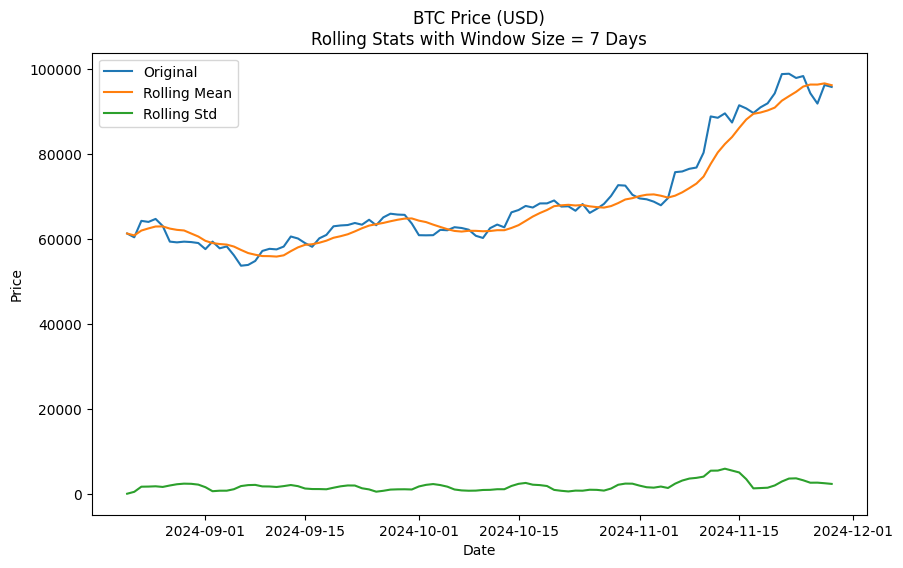

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prices, label="Original")
ax.plot(pd.Series(rolling_mean, index=prices.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=prices.index), label="Rolling Std")

ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("BTC Price (USD)\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

In [26]:
from statsmodels.tsa.arima.model import ARIMA

def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    start_date = pd.to_datetime('2024-11-29')
    end_date = start_date + pd.DateOffset(days=num_forecasts-1)
    dates = pd.date_range(start=start_date,end=end_date)
    
    forecasts = pd.Series(np.zeros(num_forecasts),index=dates)
    mod = ARIMA(ser, order=(p, 0, q), trend='ct').fit()
    
    for i in range(num_forecasts):
        forecasts[i] = mod.predict(dates[i])

    print(forecasts)
    return forecasts

p, q, num_forecasts = 7, 7, 20
forecasts = arma_log_ret(prices, p, q, num_forecasts)

/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rlieu/machine-learning/.venv/lib/python

2024-11-29    97360.287673
2024-11-30    97773.714810
2024-12-01    97648.878973
2024-12-02    97948.985603
2024-12-03    96867.341788
2024-12-04    95851.909646
2024-12-05    95589.270572
2024-12-06    96791.413281
2024-12-07    97911.262074
2024-12-08    98315.013950
2024-12-09    98366.146398
2024-12-10    97992.849655
2024-12-11    97609.434382
2024-12-12    97069.911431
2024-12-13    97392.708251
2024-12-14    98136.035847
2024-12-15    99025.294677
2024-12-16    99385.142451
2024-12-17    99338.549554
2024-12-18    99137.346324
Freq: D, dtype: float64


/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_74335/1512092749.py:17: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecasts[i] = mod.predict(dates[i])


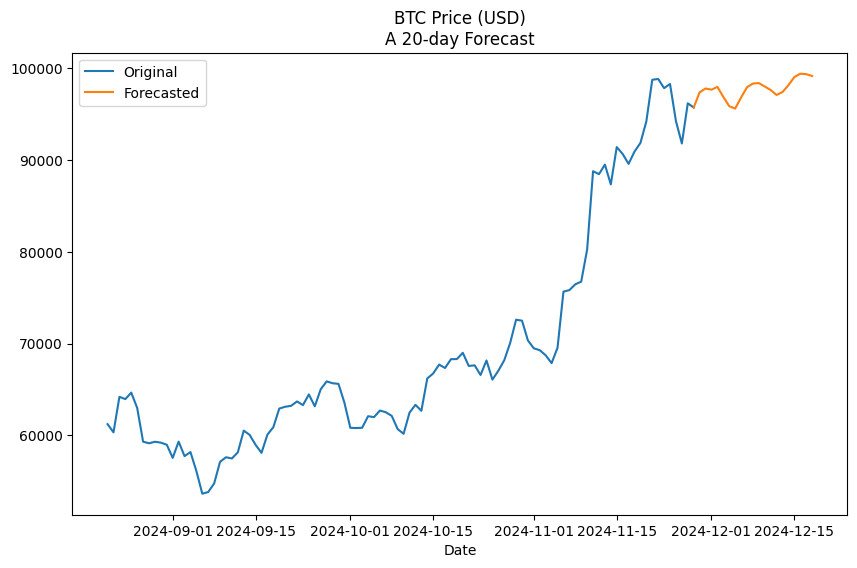

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prices, label="Original")
ax.plot(pd.concat([prices[-1:], forecasts]), label="Forecasted")

ax.set_xlabel("Date")
ax.set_title("BTC Price (USD)\n" + f"A {len(forecasts)}-day Forecast")
ax.legend()